# State-of-the-Art Speech Recognition Model Comparison

comparing different state-of-the-art speech recognition models with a focus on Wav2Vec 2.0 as the baseline. We'll evaluate models on different aspects:

1. Accuracy (Word Error Rate - WER) and (character Error Rate - CER)
2. Processing Speed
3. Memory Usage
4. Language Support
5. Resource Requirements

Models to compare:
1. Wav2Vec 2.0 (Base - wav2vec2-base-100h)
2. Wav2Vec 2.0 (Large - wav2vec2-base-960h)
3. Whisper (Small)
4. XLSR-53 (Multilingual)

In [1]:
import torch
import torchaudio
import librosa
import soundfile as sf
import numpy as np
import pandas as pd
from transformers import (
    Wav2Vec2ForCTC, 
    Wav2Vec2Processor,
    WhisperForConditionalGeneration,
    WhisperProcessor,
    AutoModelForCTC
)
import transformers
import time
import psutil
import matplotlib.pyplot as plt
from pathlib import Path
from jiwer import wer
import warnings
import subprocess
warnings.filterwarnings('ignore')


E:\MLProject_StateOfArt\backend\mlstateofartenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def check_dependencies():
    """Verifying all required packages are installed"""
    try:
        import google.protobuf
        import sentencepiece
        print("Required packages verified:")
        print(f"=>protobuf {google.protobuf.__version__}")
        print(f"=>torch {torch.__version__}")
        print(f"=>torchaudio {torchaudio.__version__}")
        print(f"=>transformers {transformers.__version__}")
        
        # Checking FFmpeg
        try:
            result = subprocess.run(['ffmpeg', '-version'], capture_output=True, text=True)
            if result.returncode == 0:
                ffmpeg_ver = result.stdout.split('\n')[0]
                print(f"=>{ffmpeg_ver}")
            else:
                print("FFmpeg check failed - we'll make sure it's in PATH")
        except Exception as e:
            print(f"FFmpeg not found: {str(e)}")
            print("\nTo fix, run in your terminal:")
            print("winget install Gyan.FFmpeg")
            raise
            
    except ImportError as e:
        print("Missing required package:", str(e))
        print("\nTo fix, run in your terminal:")
        print("pip install protobuf>=3.20.0 sentencepiece librosa")
        print("\nThen restart the kernel.")
        raise

# memory optimization
torch.backends.cudnn.enabled = False
torch.set_num_threads(4)  #limit CPU threads for laptop

def print_system_info():
    """printing the system information"""
    print(f"PyTorch Version: {torch.__version__}")
    print(f"Available Memory: {psutil.virtual_memory().available / 1024 / 1024 / 1024:.1f}GB")
    print(f"CPU Threads: {torch.get_num_threads()}")
    
print("\nsystem information:")
print_system_info()
print("\npackages information")
check_dependencies()


system information:
PyTorch Version: 2.9.0+cpu
Available Memory: 1.7GB
CPU Threads: 4

packages information
Required packages verified:
=>protobuf 6.33.0
=>torch 2.9.0+cpu
=>torchaudio 2.9.0+cpu
=>transformers 4.57.1
=>ffmpeg version 8.0-essentials_build-www.gyan.dev Copyright (c) 2000-2025 the FFmpeg developers


In [3]:
# Define models to compare
MODELS = {
    "wav2vec2-small": {  
        "name": "facebook/wav2vec2-base-100h",
        "type": "wav2vec2",
        "description": "Smaller Wav2Vec2 (trained on 100h, faster)"
    },
    "wav2vec2-base": {
        "name": "facebook/wav2vec2-base-960h",
        "type": "wav2vec2",
        "description": "Base Wav2Vec2 (960h training)"
    },
    "whisper-small": {
        "name": "openai/whisper-small",
        "type": "whisper",
        "description": "OpenAI Whisper (small, multilingual)"
    },
    "xlsr-english": {
        "name": "jonatasgrosman/wav2vec2-large-xlsr-53-english",
        "type": "wav2vec2",
        "description": "XLSR-53 fine-tuned for English"
    },

}

In [4]:
print("Available models:")
for name, info in MODELS.items():
    print(f"=>{name:<15} - {info['description']}")


Available models:
=>wav2vec2-small  - Smaller Wav2Vec2 (trained on 100h, faster)
=>wav2vec2-base   - Base Wav2Vec2 (960h training)
=>whisper-small   - OpenAI Whisper (small, multilingual)
=>xlsr-english    - XLSR-53 fine-tuned for English


In [5]:
class ModelWrapper:
    def __init__(self, model_config):
        self.config = model_config
        self.model = None
        self.processor = None

    def load(self):
        """Load model with memory optimization"""
        print(f"\nLoading {self.config['name']}...")
        try:
            if self.config["type"]=="wav2vec2":
                self.processor = Wav2Vec2Processor.from_pretrained(self.config["name"])
                self.model = Wav2Vec2ForCTC.from_pretrained(
                    self.config["name"],
                    low_cpu_mem_usage=True
                )
            else:
                # whisper
                self.processor = WhisperProcessor.from_pretrained(self.config["name"])
                self.model = WhisperForConditionalGeneration.from_pretrained(
                    self.config["name"],
                    low_cpu_mem_usage=True
                )
            self.model.eval()
            print(f"Loaded {self.config['name']}")
            return self
        except Exception as e:
            print(f"Error loading {self.config['name']}: {str(e)}")
            raise

    def transcribe(self, audio, sr):
        """transcribe audio"""
        if self.config["type"] == "wav2vec2":
            if audio.ndim > 1:
                audio = audio.mean(axis=1)
            inputs = self.processor(audio, sampling_rate=sr, return_tensors="pt", padding=True)
            with torch.no_grad():
                logits = self.model(inputs.input_values).logits
            ids = torch.argmax(logits, dim=-1)
            return self.processor.batch_decode(ids)[0]
        else:
            # whisper
            inputs = self.processor(audio, sampling_rate=sr, return_tensors="pt")
            with torch.no_grad():
                generated_ids = self.model.generate(inputs.input_features)
            return self.processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

    def unload(self):
        """Free memory"""
        try:
            del self.model
            del self.processor
            torch.cuda.empty_cache()
            import gc
            gc.collect()
            print(f"Unloaded model and freed memory")
        except Exception as e:
            print(f"Error during unload: {str(e)}")


In [6]:
# Load test datasets
def load_test_audio(audio_path, max_duration=30):
    """Load test audio file with duration limit"""
    try:
        # Try librosa first (better resampling)
        try:
            audio, sr = librosa.load(audio_path, sr=16000, duration=max_duration)
            print(f"Loaded {audio_path} with librosa")
            return audio, sr
        except Exception as e:
            print(f"Librosa load failed, trying soundfile: {str(e)}")
            
        # Fallback to soundfile
        audio, sr = sf.read(audio_path)
        if len(audio) > sr * max_duration:
            audio = audio[:sr * max_duration]
            print(f"Truncated {audio_path} to {max_duration}s")
        
        # Convert to mono if stereo
        if len(audio.shape) > 1:
            audio = librosa.to_mono(audio.T)
        
        # Resample to 16kHz if needed
        if sr != 16000:
            audio = librosa.resample(audio, orig_sr=sr, target_sr=16000)
            sr = 16000
            print(f"Resampled to {sr}Hz")
            
        return audio, sr
    except Exception as e:
        print(f"Error loading {audio_path}: {str(e)}")
        return None, None

# Define test datasets
TEST_FILES = {
    "english": [
        "./data/test/eng1.wav",
        "./data/test/eng2.wav"
    ],
}

print("\nLoading Reference Texts:")
# Load reference texts (if available)
REFERENCE_TEXTS = {}
try:
    ref_path = Path("./data/test/references.txt")
    if ref_path.exists():
        print(f"Found references file at: {ref_path.absolute()}")
        # Open with utf-8 and replace invalid chars to avoid mojibake issues
        with open(ref_path, encoding='utf-8', errors='replace') as f:
            for line in f:
                line = line.strip()
                if '\t' in line:  # expect tab-separated
                    fname, text = line.split('\t', 1)
                    REFERENCE_TEXTS[fname.strip()] = text.strip()
                    print(f"Loaded reference for {fname}:")
                    print(f"Text: \"{text.strip()}\"")
                else:
                    print(f"Skipping malformed line: {line}")
        
        # Verify all test files have references
        print("\nChecking reference coverage:")
        for lang, files in TEST_FILES.items():
            for fpath in files:
                fname = Path(fpath).name
                if fname in REFERENCE_TEXTS:
                    print(f"{fname} has reference text")
                else:
                    print(f"Missing reference for {fname}")
    else:
        print("No references.txt found, WER will use placeholder text")
except Exception as e:
    print(f"Error loading references: {str(e)}")

def get_reference_text(file_path):
    """Get reference text for a file, or return a notice if missing"""
    base_name = Path(file_path).name
    text = REFERENCE_TEXTS.get(base_name, "Reference text not available")
    if text == "Reference text not available":
        print(f"No reference text found for {base_name}")
    return text

# we'll Use jiwer transforms to normalize both reference and hypothesis consistently
from jiwer import wer,cer, Compose, ToLowerCase, RemovePunctuation, RemoveMultipleSpaces, Strip

# define transform
TRANSFORM_FOR_WER = Compose([
    ToLowerCase(),
    RemovePunctuation(),
    RemoveMultipleSpaces(),
    Strip()
])

def evaluate_model(model_wrapper, audio, sr, reference_text):
    """Evaluate model and compute WER"""
    start_time = time.time()
    mem_start = psutil.Process().memory_info().rss

    try:
        transcription = model_wrapper.transcribe(audio, sr)
        process_time = time.time() - start_time
        mem_used = (psutil.Process().memory_info().rss - mem_start) / 1024 / 1024

        if reference_text and reference_text != "Reference text not available":
            ref_transformed = TRANSFORM_FOR_WER(reference_text)
            hyp_transformed = TRANSFORM_FOR_WER(transcription)
            error_rate = wer(ref_transformed, hyp_transformed)
            cer_value = cer(ref_transformed, hyp_transformed)

            print(f"\nReference: \"{reference_text}\"")
            print(f"Generated: \"{transcription}\"")
            print(f"Computed WER: {error_rate:.3f}")
            print(f"WER Rating: {'Excellent' if error_rate <= 0.1 else 'Good' if error_rate <= 0.3 else 'Fair' if error_rate <= 0.5 else 'Poor'}")
            print(f"Computed CER: {cer_value:.3f}")
        else:
            error_rate = float('nan')
            print("No reference text available for WER calculation")

        return {
            "wer": error_rate,
            "cer": cer_value,
            "time": process_time,
            "memory": mem_used,
            "transcription": transcription,
            "reference": reference_text
        }

    except Exception as e:
        print(f"Error evaluating model: {str(e)}")
        return None

# verify test files exist
print("\nChecking test files...")
for lang, files in TEST_FILES.items():
    for fpath in files:
        if Path(fpath).exists():
            print(f"Found {fpath}")
        else:
            print(f"Missing {fpath}")



Loading Reference Texts:
Found references file at: C:\Users\sriteja\Desktop\Sem-I\ML\Codes\MLStateOfArtProject\stateofart\data\test\references.txt
Loaded reference for eng1.wav:
Text: "The boy swore that, every time he heard the alarm, he would heed its message."
Loaded reference for eng2.wav:
Text: "Their faces were hidden behind blue veils, with only their eyes showing"

Checking reference coverage:
eng1.wav has reference text
eng2.wav has reference text

Checking test files...
Found ./data/test/eng1.wav
Found ./data/test/eng2.wav


## Run Model Comparison

Now let's compare the models on:
1. Short audio clips (< 30s)
2. Different languages
3. Different speech patterns (fast/slow, accents)

In [7]:
# %pip install torchcodec


In [8]:
# !pip install huggingface_hub[hf_xet]

In [9]:
import pandas as pd
import numpy as np

results = {}

for model_name, config in MODELS.items():
    print(f"\nEvaluating {model_name}")
    
    try:
        model = ModelWrapper(config).load()
    except Exception as e:
        print(f"Error loading {model_name}: {e}")
        continue

    results[model_name] = []
    processed_files = set()  # avoiding duplicates

    for lang, files in TEST_FILES.items():
        for file_path in files:
            if file_path in processed_files:
                continue
            processed_files.add(file_path)

            try:
                # Use our improved audio loading function
                audio, sr = load_test_audio(file_path)
                if audio is None:
                    print(f"Skipping {file_path}, audio not loaded")
                    continue

                reference_text = get_reference_text(file_path)
                print(f"\nProcessing {file_path}")

                result = evaluate_model(model, audio, sr, reference_text)
                if not result:
                    continue

                # ensuring numeric fields
                result["memory"] = max(result.get("memory", 0), 0)
                result["wer"] = result.get("wer", np.nan)

                result["file"] = file_path
                result["language"] = lang
                results[model_name].append(result)

                print(f"Time: {result['time']:.2f}s")
                print(f"Memory: {result['memory']:.1f}MB")
                if not np.isnan(result["wer"]):
                    print(f"WER: {result['wer']:.3f}")
                print(f"Output: {result['transcription'][:100]}...")
                if reference_text != "Reference text not available":
                    print(f"Expected: {reference_text[:100]}...")

            except Exception as e:
                print(f"Error processing {file_path}: {e}")

    print(f"\nUnloading {model_name}...")
    try:
        model.unload()
        print(f"Unloaded {model_name} and freed memory")
    except Exception as e:
        print(f"Error unloading {model_name}: {e}")


# Convert results to DataFrame safely
df_results = [
    {
        "model": model_name,
        "language": r.get("language", "unknown"),
        "wer": r.get("wer", np.nan),
        "cer": r.get("cer", np.nan),
        "time": r.get("time", np.nan),
        "memory": r.get("memory", np.nan),
        "file": r.get("file", "unknown")
    }
    for model_name, model_results in results.items()
    for r in model_results
]

df = pd.DataFrame(df_results)

print("\nResults DataFrame Preview:")
print(df.head())

# Handle missing or empty dataframe
if df.empty:
    print("No results to summarize - check if evaluation produced any output.")
else:
    # Print summary
    print("\nResults Summary:")
    summary = df.groupby("model").agg({
        "wer": ["mean", "std"],
        "cer": ["mean", "std"],
        "time": ["mean", "std"],
        "memory": ["mean", "std"]
    }).round(3)

    print("\nMetrics by model (mean ± std):")
    for model in summary.index:
        wer_mean = summary.loc[model, ("wer", "mean")]
        wer_std = summary.loc[model, ("wer", "std")]
        time_mean = summary.loc[model, ("time", "mean")]
        time_std = summary.loc[model, ("time", "std")]
        mem_mean = summary.loc[model, ("memory", "mean")]
        mem_std = summary.loc[model, ("memory", "std")]
        cer_mean = summary.loc[model, ("cer", "mean")]
        cer_std = summary.loc[model, ("cer", "std")]
        

        print(f"\n{model}:")
        if not np.isnan(wer_mean):
            print(f"WER: {wer_mean:.3f} ± {wer_std:.3f}")
        if not np.isnan(cer_mean):
            print(f"CER: {cer_mean:.3f} ± {cer_std:.3f}")
        print(f"Time: {time_mean:.2f}s ± {time_std:.2f}s")
        print(f"Memory: {mem_mean:.1f}MB ± {mem_std:.1f}MB")


Evaluating wav2vec2-small

Loading facebook/wav2vec2-base-100h...


Some weights of the model checkpoint at facebook/wav2vec2-base-100h were not used when initializing Wav2Vec2ForCTC: ['wav2vec2.mask_time_emb_vector']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-100h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loaded facebook/wav2vec2-base-100h
Loaded ./data/test/eng1.wav with librosa

Processing ./data/test/eng1.wav

Reference: "The boy swore that, every time he heard the alarm, he would heed its message."
Generated: "AND THE BOY SAW THAT EVERY TIME HE HEARD THE ALARM HE WOULD HEAD ITS MESSAGE"
Computed WER: 0.200
WER Rating: Good
Computed CER: 0.122
Time: 1.04s
Memory: 401.6MB
WER: 0.200
Output: AND THE BOY SAW THAT EVERY TIME HE HEARD THE ALARM HE WOULD HEAD ITS MESSAGE...
Expected: The boy swore that, every time he heard the alarm, he would heed its message....
Loaded ./data/test/eng2.wav with librosa

Processing ./data/test/eng2.wav

Reference: "Their faces were hidden behind blue veils, with only their eyes showing"
Generated: "THEIR FACES WERE HIDDEN BEHIND BLUE VEILS WITH ONLY THE EYES SHOWING"
Computed WER: 0.083
WER Rating: Excellent
Computed CER: 0.029
Time: 1.09s
Memory: 62.4MB
WER: 0.083
Output: THEIR FACES WERE HIDDEN BEHIND BLUE VEILS WITH ONLY THE EYES SHOWING...
Expected: Th

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loaded facebook/wav2vec2-base-960h
Loaded ./data/test/eng1.wav with librosa

Processing ./data/test/eng1.wav

Reference: "The boy swore that, every time he heard the alarm, he would heed its message."
Generated: "THE BOY SAW THAT EVERY TIME HE HEARD THE ALARM HE WOULD HEED ITS MESSAGE"
Computed WER: 0.067
WER Rating: Excellent
Computed CER: 0.054
Time: 2.26s
Memory: 358.7MB
WER: 0.067
Output: THE BOY SAW THAT EVERY TIME HE HEARD THE ALARM HE WOULD HEED ITS MESSAGE...
Expected: The boy swore that, every time he heard the alarm, he would heed its message....
Loaded ./data/test/eng2.wav with librosa

Processing ./data/test/eng2.wav

Reference: "Their faces were hidden behind blue veils, with only their eyes showing"
Generated: "THEIR FACES WERE HIDDEN BEHIND BLUE VEILS WITH ONLY THEIR EYES SHOWING"
Computed WER: 0.000
WER Rating: Excellent
Computed CER: 0.000
Time: 1.07s
Memory: 2.1MB
WER: 0.000
Output: THEIR FACES WERE HIDDEN BEHIND BLUE VEILS WITH ONLY THEIR EYES SHOWING...
Expected: Th

Using custom `forced_decoder_ids` from the (generation) config. This is deprecated in favor of the `task` and `language` flags/config options.
Transcription using a multilingual Whisper will default to language detection followed by transcription instead of translation to English. This might be a breaking change for your use case. If you want to instead always translate your audio to English, make sure to pass `language='en'`. See https://github.com/huggingface/transformers/pull/28687 for more details.


Loaded openai/whisper-small
Loaded ./data/test/eng1.wav with librosa

Processing ./data/test/eng1.wav


The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.



Reference: "The boy swore that, every time he heard the alarm, he would heed its message."
Generated: " The boy swore that every time he heard the alarm, he would heed its message."
Computed WER: 0.000
WER Rating: Excellent
Computed CER: 0.000
Time: 15.80s
Memory: 964.0MB
WER: 0.000
Output:  The boy swore that every time he heard the alarm, he would heed its message....
Expected: The boy swore that, every time he heard the alarm, he would heed its message....
Loaded ./data/test/eng2.wav with librosa

Processing ./data/test/eng2.wav

Reference: "Their faces were hidden behind blue veils, with only their eyes showing"
Generated: " The faces were hidden behind blue veils with only the eyes showing."
Computed WER: 0.167
WER Rating: Good
Computed CER: 0.057
Time: 10.99s
Memory: 0.0MB
WER: 0.167
Output:  The faces were hidden behind blue veils with only the eyes showing....
Expected: Their faces were hidden behind blue veils, with only their eyes showing...

Unloading whisper-small...
Unloa

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   model     8 non-null      object 
 1   language  8 non-null      object 
 2   wer       8 non-null      float64
 3   cer       8 non-null      float64
 4   time      8 non-null      float64
 5   memory    8 non-null      float64
 6   file      8 non-null      object 
dtypes: float64(4), object(3)
memory usage: 576.0+ bytes
None

DataFrame Head:
            model language       wer       cer       time      memory  \
0  wav2vec2-small  english  0.200000  0.121622   1.042588  401.593750   
1  wav2vec2-small  english  0.083333  0.028571   1.086568   62.441406   
2   wav2vec2-base  english  0.066667  0.054054   2.262389  358.656250   
3   wav2vec2-base  english  0.000000  0.000000   1.066125    2.050781   
4   whisper-small  english  0.000000  0.000000  15.795361  964.003906   

               

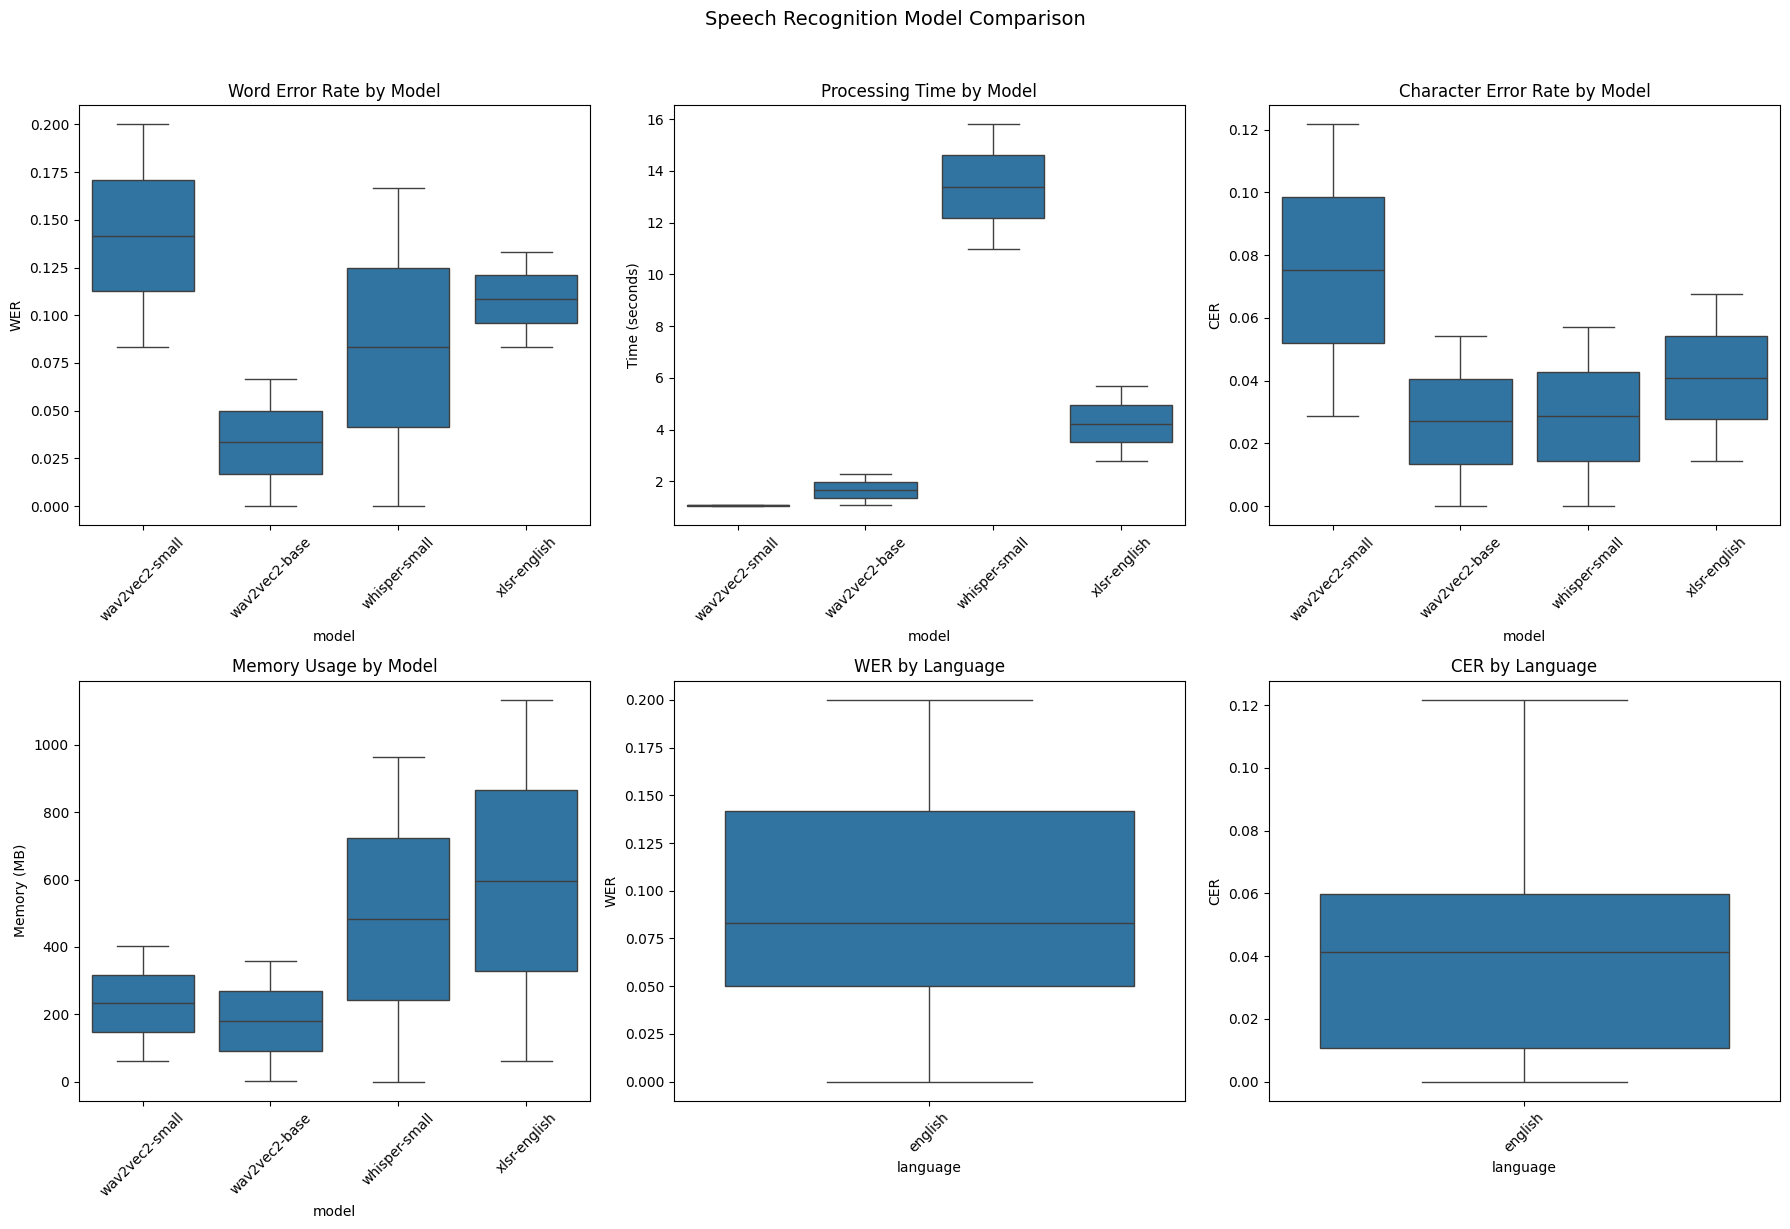


Detailed Statistics:

Detailed results by model and language:

wav2vec2-base - english:
WER: 0.033 ± 0.047 (n=2)
CER: 0.027 ± 0.038
Time: 1.66s ± 0.85s
Memory: 180.4MB ± 252.2MB

wav2vec2-small - english:
WER: 0.142 ± 0.082 (n=2)
CER: 0.075 ± 0.066
Time: 1.06s ± 0.03s
Memory: 232.0MB ± 239.8MB

whisper-small - english:
WER: 0.083 ± 0.118 (n=2)
CER: 0.029 ± 0.040
Time: 13.39s ± 3.40s
Memory: 482.0MB ± 681.7MB

xlsr-english - english:
WER: 0.108 ± 0.035 (n=2)
CER: 0.041 ± 0.038
Time: 4.23s ± 2.05s
Memory: 596.5MB ± 759.2MB

Saving results to C:\Users\sriteja\Desktop\Sem-I\ML\Codes\MLStateOfArtProject\stateofart\data\test\results.csv
Successfully saved 8 rows of data
Columns saved: model, language, wer, cer, time, memory, file


In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

# First, verify we have data to plot
print("DataFrame Info:")
print(df.info())
print("\nDataFrame Head:")
print(df.head())

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle("Speech Recognition Model Comparison", fontsize=14, y=1.02)

# WER by model
if not df["wer"].isna().all():
    sns.boxplot(x="model", y="wer", data=df, ax=axes[0,0])
    axes[0,0].set_title("Word Error Rate by Model")
    axes[0,0].set_ylabel("WER")
    axes[0,0].tick_params(axis='x', rotation=45)
else:
    print("No WER values available for plotting")
    axes[0,0].remove()

# CER by model
if "cer" in df.columns and not df["cer"].isna().all():
    sns.boxplot(x="model", y="cer", data=df, ax=axes[0,2])
    axes[0,2].set_title("Character Error Rate by Model")
    axes[0,2].set_ylabel("CER")
    axes[0,2].tick_params(axis='x', rotation=45)
else:
    print("No CER values available for plotting")
    axes[0,2].remove()


# Processing time by model
sns.boxplot(x="model", y="time", data=df, ax=axes[0,1])
axes[0,1].set_title("Processing Time by Model")
axes[0,1].set_ylabel("Time (seconds)")
axes[0,1].tick_params(axis='x', rotation=45)

# Memory usage by model
sns.boxplot(x="model", y="memory", data=df, ax=axes[1,0])
axes[1,0].set_title("Memory Usage by Model")
axes[1,0].set_ylabel("Memory (MB)")
axes[1,0].tick_params(axis='x', rotation=45)

# WER by language
if not df["wer"].isna().all():
    sns.boxplot(x="language", y="wer", data=df, ax=axes[1,1])
    axes[1,1].set_title("WER by Language")
    axes[1,1].set_ylabel("WER")
    axes[1,1].tick_params(axis='x', rotation=45)
else:
    axes[1,1].remove()


# CER by language
if not df["cer"].isna().all():
    sns.boxplot(x="language", y="cer", data=df, ax=axes[1,2])
    axes[1,2].set_title("CER by Language")
    axes[1,2].set_ylabel("CER")
    axes[1,2].tick_params(axis='x', rotation=45)
else:
    axes[1,2].remove()


plt.tight_layout()
plt.show()

# Print detailed statistics
print("\nDetailed Statistics:")
stats = df.groupby(["model", "language"]).agg({
    "wer": ["mean", "std", "count"],
    "cer": ["mean", "std"],
    "time": ["mean", "std"],
    "memory": ["mean", "std"]
}).round(3)

print("\nDetailed results by model and language:")
for (model, lang), row in stats.iterrows():
    print(f"\n{model} - {lang}:")
    if not np.isnan(row[("wer", "mean")]):
        print(f"WER: {row[('wer', 'mean')]:.3f} ± {row[('wer', 'std')]:.3f} (n={int(row[('wer', 'count')])})")
    if not np.isnan(row[("cer", "mean")]):
        print(f"CER: {row[('cer', 'mean')]:.3f} ± {row[('cer', 'std')]:.3f}")
    print(f"Time: {row[('time', 'mean')]:.2f}s ± {row[('time', 'std')]:.2f}s")
    print(f"Memory: {row[('memory', 'mean')]:.1f}MB ± {row[('memory', 'std')]:.1f}MB")

# Save results with verification
results_file = Path("./data/test/results.csv")
try:
    # Create directory if it doesn't exist
    results_file.parent.mkdir(parents=True, exist_ok=True)
    
    # Save the data
    print(f"\nSaving results to {results_file.absolute()}")
    df.to_csv(results_file, index=False)
    
    # Verify the save by reading it back
    df_verify = pd.read_csv(results_file)
    if len(df_verify) == len(df):
        print(f"Successfully saved {len(df)} rows of data")
        print(f"Columns saved: {', '.join(df_verify.columns)}")
    else:
        print(f"Data verification failed: Saved {len(df_verify)} rows but expected {len(df)}")
        
except Exception as e:
    print(f"Error saving results: {str(e)}")
    print(f"Current working directory: {Path.cwd()}")
    print(f"Target save path: {results_file.absolute()}")

In [11]:
import pandas as pd
import numpy as np

# load saved results
df = pd.read_csv("./data/test/results.csv")

# WER Table
if df['wer'].isnull().all():
    print("No WER values found. Make sure reference texts are available for comparison.")
else:
    wer_table = df.pivot_table(
        index="language",
        columns="model",
        values="wer",
        aggfunc="mean"
    ).round(3)

    print("WER Table:")
    print(wer_table)
    print("\nWER Score Guide:")
    print("0.0-0.1: Excellent")
    print("0.1-0.3: Good")
    print("0.3-0.5: Fair")
    print(">0.5: Poor")

# CER Table
if "cer" in df.columns and not df["cer"].isnull().all():
    cer_table = df.pivot_table(
        index="language",
        columns="model",
        values="cer",
        aggfunc="mean"
    ).round(3)

    print("\n=== CER Table ===")
    print(cer_table)
    print("\nCER Score Guide:")
    print("0.0-0.05: Excellent")
    print("0.05-0.2: Good")
    print("0.2-0.4: Fair")
    print(">0.4: Poor")
else:
    print("\nNo CER values found or column missing.")

# Processing Time
time_table = df.pivot_table(
    index="language",
    columns="model",
    values="time",
    aggfunc="mean"
).round(2)

print("\nProcessing Time Table (s)")
print(time_table)

# Memory
memory_table = df.pivot_table(
    index="language",
    columns="model",
    values="memory",
    aggfunc="mean"
).round(1)

print("\nMemory Usage Table (MB)")
print(memory_table)

# Summary by Model
print("\nSummary by Model")
model_stats = df.groupby('model').agg({
    'wer': lambda x: f"{x.mean():.3f} ({'Excellent' if x.mean() <= 0.1 else 'Good' if x.mean() <= 0.3 else 'Fair' if x.mean() <= 0.5 else 'Poor'})" if not x.isnull().all() else "N/A",
    'cer': lambda x: f"{x.mean():.3f} ({'Excellent' if x.mean() <= 0.05 else 'Good' if x.mean() <= 0.2 else 'Fair' if x.mean() <= 0.4 else 'Poor'})" if not x.isnull().all() else "N/A",
    'time': lambda x: f"{x.mean():.2f}s",
    'memory': lambda x: f"{x.mean():.1f}MB"
}).round(3)

print("\nModel Performance (WER | CER | Processing Time | Memory):")
for model in model_stats.index:
    print(f"{model}:")
    print(f"WER: {model_stats.loc[model, 'wer']}")
    print(f"CER: {model_stats.loc[model, 'cer']}")
    print(f"Time: {model_stats.loc[model, 'time']}")
    print(f"Memory: {model_stats.loc[model, 'memory']}")


WER Table:
model     wav2vec2-base  wav2vec2-small  whisper-small  xlsr-english
language                                                            
english           0.033           0.142          0.083         0.108

WER Score Guide:
0.0-0.1: Excellent
0.1-0.3: Good
0.3-0.5: Fair
>0.5: Poor

=== CER Table ===
model     wav2vec2-base  wav2vec2-small  whisper-small  xlsr-english
language                                                            
english           0.027           0.075          0.029         0.041

CER Score Guide:
0.0-0.05: Excellent
0.05-0.2: Good
0.2-0.4: Fair
>0.4: Poor

Processing Time Table (s)
model     wav2vec2-base  wav2vec2-small  whisper-small  xlsr-english
language                                                            
english            1.66            1.06          13.39          4.23

Memory Usage Table (MB)
model     wav2vec2-base  wav2vec2-small  whisper-small  xlsr-english
language                                                            
engli

# Understanding WER (Word Error Rate)

WER measures the minimum number of edits needed to change the transcribed text into the reference text, divided by the number of words in the reference.

WER = (Substitutions + Deletions + Insertions) / Number of Reference Words

- **WER = 0.0**: Perfect match (best possible score)
- **WER = 0.2**: 20% error rate (good for conversational speech)
- **WER = 0.5**: 50% error rate (poor performance)
- **WER > 1.0**: Very poor performance (more errors than reference words)

Lower WER is always better. State-of-the-art models typically achieve:
- English: 0.02 - 0.15 (2-15% WER)
- Other languages: 0.05 - 0.30 (5-30% WER)
- Noisy/accented speech: Up to 0.50 (50% WER)


# Understanding CER (Character Error Rate)

CER measures transcription accuracy at the character level.  
It counts the number of character-level edits needed to match the reference text.

**CER = (Substitutions + Deletions + Insertions) / Number of Reference Characters**

### Example interpretation
- **CER = 0.0** -> perfect match  
- **CER = 0.1** -> 10% character-level error rate (high accuracy)  
- **CER = 0.3** -> moderate accuracy  
- **CER > 0.5** -> poor performance  

### Typical CER ranges
- **Clean English speech:** 0.02 - 0.10  
- **Other languages:** 0.05 - 0.20  
- **Noisy or accented speech:** up to 0.40  

CER is more sensitive than WER—it detects smaller spelling and phone


In [12]:
# Test WER calculation with sample files
print("Testing WER Calculation:")

# Test with a single file first
test_file = "./data/test/eng1.wav"
audio, sr = load_test_audio(test_file)
if audio is not None:
    reference = get_reference_text(test_file)
    result = evaluate_model(ModelWrapper(MODELS['whisper-small']).load(), audio, sr, reference)
    print("\nDetailed WER Analysis:")
    if result and not np.isnan(result['wer']):
        print(f"Final WER: {result['wer']:.3f}")

Testing WER Calculation:
Loaded ./data/test/eng1.wav with librosa

Loading openai/whisper-small...
Loaded openai/whisper-small

Reference: "The boy swore that, every time he heard the alarm, he would heed its message."
Generated: " The boy swore that every time he heard the alarm, he would heed its message."
Computed WER: 0.000
WER Rating: Excellent
Computed CER: 0.000

Detailed WER Analysis:
Final WER: 0.000


In [13]:
# !pip install datasets


In [14]:
import sys
print(sys.executable)


E:\MLProject_StateOfArt\backend\mlstateofartenv\Scripts\python.exe


10 10

Loading facebook/wav2vec2-base-100h...


Some weights of the model checkpoint at facebook/wav2vec2-base-100h were not used when initializing Wav2Vec2ForCTC: ['wav2vec2.mask_time_emb_vector']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-100h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loaded facebook/wav2vec2-base-100h

Reference: "He was buried in Lahore near Anarkali Bazaar."
Generated: "HE WAS BURIED IN LAHOR NEAR ANNACOLLI BAZAR"
Computed WER: 0.375
WER Rating: Fair
Computed CER: 0.136

Reference: "A dog trying to catch bubbles from a bubble machine in the grass"
Generated: "A DOG TRYING TO CATCH BOBBLES FROM A BOBBLE MACHINE IN THE GRASS"
Computed WER: 0.154
WER Rating: Good
Computed CER: 0.031

Reference: "One should always leave a light burning in an empty theatre."
Generated: "ONE SHOULD ALWAYS LEAVE A LIGHT BURNING IN AN EMPTY THEATRE"
Computed WER: 0.000
WER Rating: Excellent
Computed CER: 0.000

Reference: "Like the Roma in general, many different ethnonyms are given to subgroups of Roma."
Generated: "LIKE THE ROMA IN GENERAL MANY DIFFERENT ETHANUMS ARE GIVEN TO SUB GROUPS OF ROMA"
Computed WER: 0.214
WER Rating: Good
Computed CER: 0.050

Reference: "She had two children from her first marriage."
Generated: "SHE HAD TWO CHILDREN FROM HER FIRST MARRIAGE"
C

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loaded facebook/wav2vec2-base-960h

Reference: "He was buried in Lahore near Anarkali Bazaar."
Generated: "HE WAS BURIED IN LAHORE NEAR ANNACALI BAZARE"
Computed WER: 0.250
WER Rating: Good
Computed CER: 0.114

Reference: "A dog trying to catch bubbles from a bubble machine in the grass"
Generated: "A DOG TRYING TO CATCH BOBBLES FROM A BOBBLE MACHINE IN THE GRASS"
Computed WER: 0.154
WER Rating: Good
Computed CER: 0.031

Reference: "One should always leave a light burning in an empty theatre."
Generated: "ONE SHOULD ALWAYS LEAVE A LIGHT BURNING IN AN EMPTY THEATRE"
Computed WER: 0.000
WER Rating: Excellent
Computed CER: 0.000

Reference: "Like the Roma in general, many different ethnonyms are given to subgroups of Roma."
Generated: "LIKE THE ROMA IN GENERAL MANY DIFFERENT ETHNEMS ARE GIVEN TO SUBGROUPS OF ROMA"
Computed WER: 0.071
WER Rating: Excellent
Computed CER: 0.037

Reference: "She had two children from her first marriage."
Generated: "SHE HAD TWO CHILDREN FROM HER FIRST MARRIAG

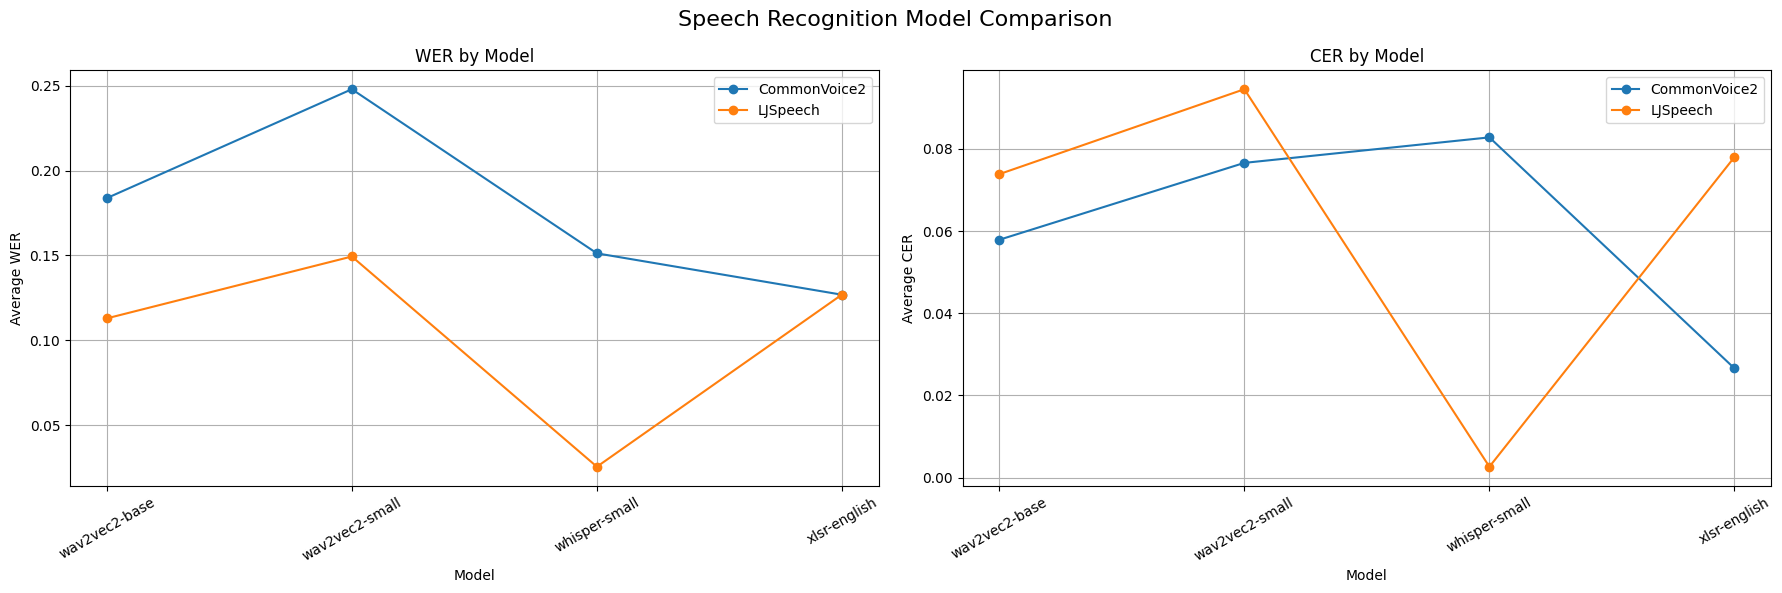

In [15]:
# Common Voice 2 + LJSpeech
import os
import pandas as pd
from datasets import Dataset
import librosa
import matplotlib.pyplot as plt
import pandas as pd


SAMPLE_SIZE = 10
SAMPLING_RATE = 16000  # or None if you want to keep original

def load_audio_librosa(file_path):
    audio, sr = librosa.load(file_path, sr=SAMPLING_RATE)
    return audio, sr

def prepare_dataset(df, text_col="text", path_col="audio_path"):
    # Filter files that exist
    df = df[df[path_col].apply(os.path.exists)]
    n_samples = min(SAMPLE_SIZE, len(df))
    df = df.sample(n_samples, random_state=42)
    
    dataset = []
    for _, row in df.iterrows():
        audio, sr = load_audio_librosa(row[path_col])
        dataset.append({
            "speech": audio,
            "sampling_rate": sr,
            "text": row[text_col]
        })
    return dataset
# Common Voice 2
cv2_df = pd.read_csv("commonvoice2/train/train.tsv", sep="\t")
cv2_df["audio_path"] = cv2_df["path"].apply(lambda x: f"./commonvoice2/train/clips/{x}.wav")
cv2_df = cv2_df[["audio_path", "sentence"]].rename(columns={"sentence": "text"})
cv2_ds = prepare_dataset(cv2_df)

# LJSpeech
lj_df = pd.read_csv("./LJSpeech-1.1/metadata.csv", sep="|", header=None, names=["path","text","_"])
lj_df["audio_path"] = lj_df["path"].apply(lambda x: f"./LJSpeech-1.1/wavs/{x}.wav")
lj_df = lj_df[["audio_path", "text"]]
lj_ds = prepare_dataset(lj_df)

print(len(cv2_ds), len(lj_ds))


# model evalutation

results = []

for model_name, config in MODELS.items():
    wrapper = ModelWrapper(config).load()
    for dataset_name, dataset in {"CommonVoice2": cv2_ds, "LJSpeech": lj_ds}.items():
        for i, sample in enumerate(dataset):
            try:
                metrics = evaluate_model(wrapper, sample["speech"], sample["sampling_rate"], sample["text"])
                if metrics:
                    metrics.update({
                        "model": model_name,
                        "dataset": dataset_name,
                        "sample_idx": i
                    })
                    results.append(metrics)
            except Exception as e:
                print(f"Error on sample {i}: {e}")
    wrapper.unload()


# saving and visualizing results

df_results = pd.DataFrame(results)
df_results.to_csv("speech_recognition_results.csv", index=False)


summary = df_results.groupby(["model", "dataset"])[["wer", "cer", "time", "memory"]].mean().reset_index()
print(summary)

fig, axes = plt.subplots(1, 2, figsize=(18, 6))
fig.suptitle("Speech Recognition Model Comparison", fontsize=16)

# WER plot
for dataset_name in summary["dataset"].unique():
    subset = summary[summary["dataset"] == dataset_name]
    axes[0].plot(subset["model"], subset["wer"], marker="o", label=dataset_name)
axes[0].set_xlabel("Model")
axes[0].set_ylabel("Average WER")
axes[0].set_title("WER by Model")
axes[0].tick_params(axis='x', rotation=30)
axes[0].grid(True)
axes[0].legend()

# CER plot
for dataset_name in summary["dataset"].unique():
    subset = summary[summary["dataset"] == dataset_name]
    axes[1].plot(subset["model"], subset["cer"], marker="o", label=dataset_name)
axes[1].set_xlabel("Model")
axes[1].set_ylabel("Average CER")
axes[1].set_title("CER by Model")
axes[1].tick_params(axis='x', rotation=30)
axes[1].grid(True)
axes[1].legend()

plt.tight_layout()
plt.show()


Saved: speech_recognition_summary.csv


,model,dataset,wer,cer,time,memory,baseline_wer,relative_wer_improvement_%,baseline_cer,relative_cer_improvement_%
0,wav2vec2-base,CommonVoice2,0.183836,0.057900,1.102786,35.688672,0.183836,0.000000,0.057900,0.000000
1,wav2vec2-base,LJSpeech,0.112897,0.073874,1.199497,0.693359,0.112897,0.000000,0.073874,0.000000
2,wav2vec2-small,CommonVoice2,0.248084,0.076619,0.947979,36.849609,0.183836,-34.948752,0.057900,-32.328227
3,wav2vec2-small,LJSpeech,0.149405,0.094549,1.220603,2.588281,0.112897,-32.337434,0.073874,-27.986087
4,whisper-small,CommonVoice2,0.151261,0.082825,14.022726,78.286719,0.183836,17.719293,0.057900,-43.046558
5,whisper-small,LJSpeech,0.025397,0.002662,11.150413,-7.560547,0.112897,77.504394,0.073874,96.396591
6,xlsr-english,CommonVoice2,0.126855,0.026595,3.014957,122.087109,0.183836,30.995366,0.057900,54.066881
7,xlsr-english,LJSpeech,0.126950,0.078037,3.417138,8.463281,0.112897,-12.447467,0.073874,-5.635612


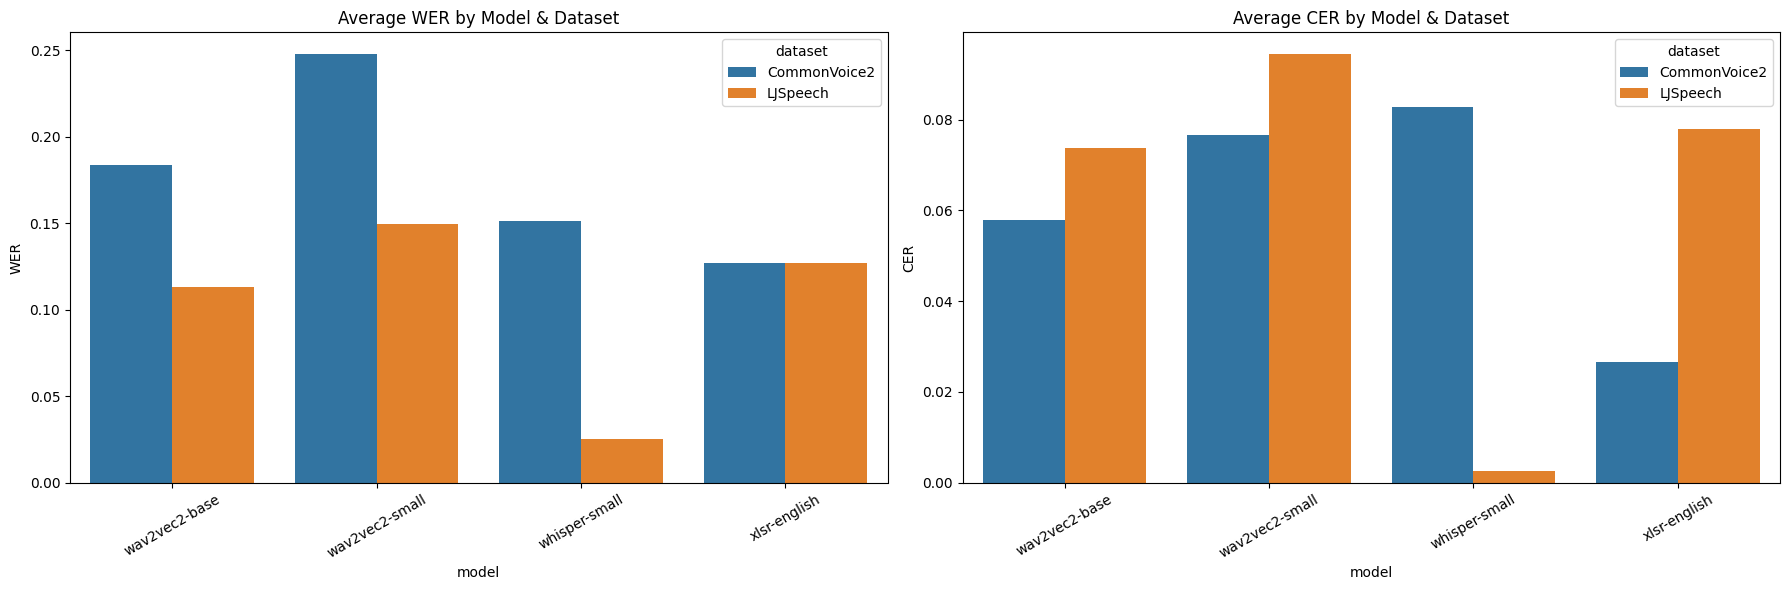

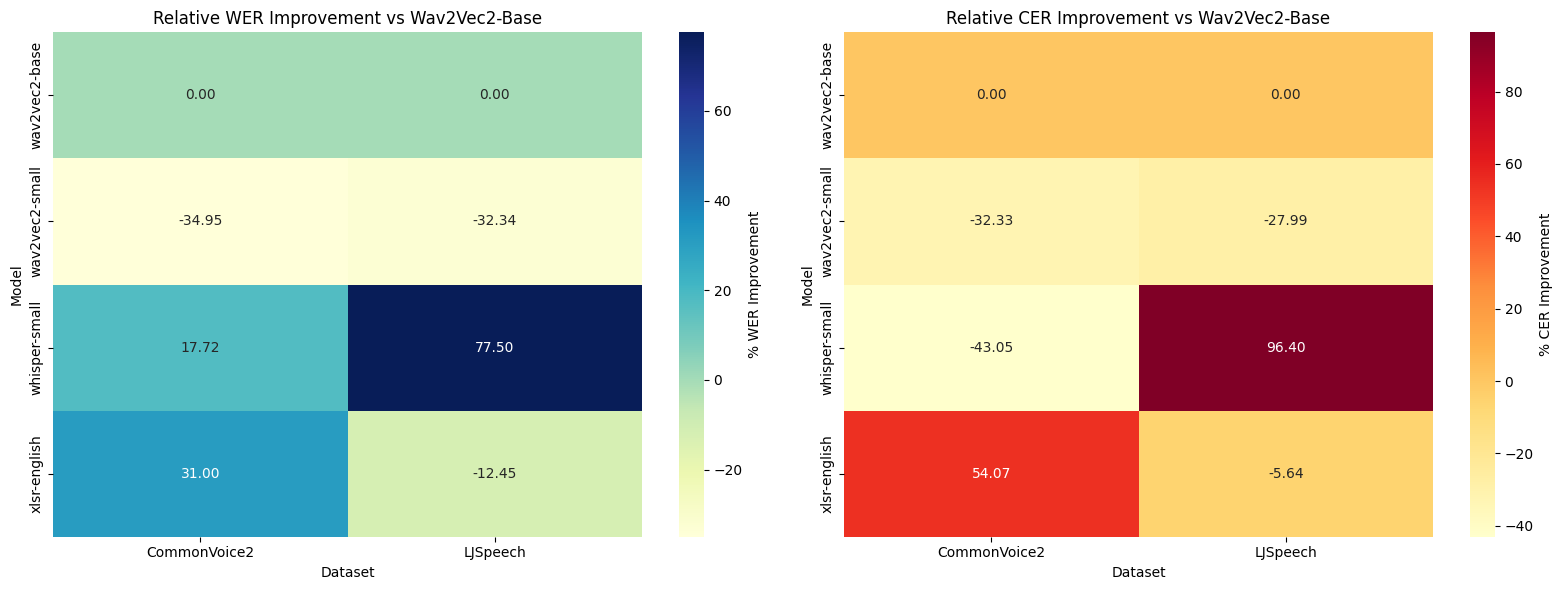

For dataset 'CommonVoice2', the best performing model is 'xlsr-english' with average WER = 0.127
For dataset 'LJSpeech', the best performing model is 'whisper-small' with average WER = 0.025
For dataset 'CommonVoice2', the best CER model is 'xlsr-english' with CER = 0.027
For dataset 'LJSpeech', the best CER model is 'whisper-small' with CER = 0.003


In [16]:
# final Comparative Analysis and Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Compute average metrics per model and dataset
summary = df_results.groupby(["model", "dataset"])[["wer","cer", "time", "memory"]].mean().reset_index()

# Compute relative WER improvement vs wav2vec2-base (baseline)
baseline = summary[summary["model"] == "wav2vec2-base"][["dataset", "wer"]].rename(columns={"wer": "baseline_wer"})
summary = summary.merge(baseline, on="dataset", how="left")
summary["relative_wer_improvement_%"] = (1 - summary["wer"] / summary["baseline_wer"]) * 100

# compute relative CER improvement vs wav2vec2-base
baseline_cer = summary[summary["model"] == "wav2vec2-base"][["dataset", "cer"]].rename(columns={"cer": "baseline_cer"})
summary = summary.merge(baseline_cer, on="dataset", how="left")
summary["relative_cer_improvement_%"] = (1 - summary["cer"] / summary["baseline_cer"]) * 100


# Save final summary
summary.to_csv("speech_recognition_summary.csv", index=False)
print("Saved: speech_recognition_summary.csv")

# display summary
display(summary)

# Visualization 1: Average WER per Model & Dataset

fig, axes = plt.subplots(1, 2, figsize=(18,6))

# WER
sns.barplot(data=summary, x="model", y="wer", hue="dataset", ax=axes[0])
axes[0].set_title("Average WER by Model & Dataset")
axes[0].set_ylabel("WER")
axes[0].tick_params(axis='x', rotation=30)

# CER
sns.barplot(data=summary, x="model", y="cer", hue="dataset", ax=axes[1])
axes[1].set_title("Average CER by Model & Dataset")
axes[1].set_ylabel("CER")
axes[1].tick_params(axis='x', rotation=30)

plt.tight_layout()
plt.show()


# Visualization 2: Relative Improvement Heatmap

# pivot tables
pivot_wer = summary.pivot_table(index="model", columns="dataset", values="relative_wer_improvement_%")
pivot_cer = summary.pivot_table(index="model", columns="dataset", values="relative_cer_improvement_%")

# create side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# WER heatmap
sns.heatmap(pivot_wer, annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={'label': '% WER Improvement'}, ax=axes[0])
axes[0].set_title("Relative WER Improvement vs Wav2Vec2-Base")
axes[0].set_xlabel("Dataset")
axes[0].set_ylabel("Model")

# CER heatmap
sns.heatmap(pivot_cer, annot=True, fmt=".2f", cmap="YlOrRd", cbar_kws={'label': '% CER Improvement'}, ax=axes[1])
axes[1].set_title("Relative CER Improvement vs Wav2Vec2-Base")
axes[1].set_xlabel("Dataset")
axes[1].set_ylabel("Model")

plt.tight_layout()
plt.show()


# insight exmaple
# Prints textual insights for your report

for dataset in summary["dataset"].unique():
    subset = summary[summary["dataset"] == dataset].sort_values("wer")
    best_model = subset.iloc[0]["model"]
    best_wer = subset.iloc[0]["wer"]
    print(f"For dataset '{dataset}', the best performing model is '{best_model}' with average WER = {best_wer:.3f}")


for dataset in summary["dataset"].unique():
    subset = summary[summary["dataset"] == dataset].sort_values("cer")
    best_model = subset.iloc[0]["model"]
    best_cer = subset.iloc[0]["cer"]
    print(f"For dataset '{dataset}', the best CER model is '{best_model}' with CER = {best_cer:.3f}")

